In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np

In [2]:
# Import the data
data = {
    '00': (np.load('data/id_00/X.npy'), np.load('data/id_00/y.npy')),
    '02': (np.load('data/id_02/X.npy'), np.load('data/id_02/y.npy')),
    '04': (np.load('data/id_04/X.npy'), np.load('data/id_04/y.npy')),
    '06': (np.load('data/id_06/X.npy'), np.load('data/id_06/y.npy')),
}
# Leave only the first column of the target
for key in data:
    data[key] = (data[key][0], data[key][1][:, 0])
# Convert the labels 1 -> 0 and 2 -> 1: 0 - normal, 1 - failure
for key in data:
    data[key] = (data[key][0], np.where(data[key][1] == 1, 1, 0))

## General approach

In [3]:
# Load the general model
model = keras.models.load_model('models/best/general.h5')

# Get the shape of the nn
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                827904    
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 834177 (3.18 MB)
Trainable params: 834177 (3.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [4]:
# Cut the last layer
new_model = tf.keras.models.Sequential(model.layers[:-1])

# Get the shape of the nn
print(new_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                827904    
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
Total params: 834144 (3.18 MB)
Trainable params: 834144 (3.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [5]:
# Merge the datasets
X_merged = np.concatenate([data[key][0] for key in data])
y_merged = np.concatenate([data[key][1] for key in data])

# Extract the features
X_merged = new_model.predict(X_merged)

X_merged.shape, y_merged.shape

1561/1561 [==============================] - 1s 798us/step


((49950, 32), (49950,))

In [6]:
dataset = [({j: X_merged[i,j] for j in range(X_merged.shape[1])}, y_merged[i]) for i in range(X_merged.shape[0])]

In [7]:
# Shuffle the dataset
import random
random.shuffle(dataset)

In [8]:
# Using river, create a streaming naive bayes classifier
from river import naive_bayes
from river import metrics
from river import evaluate

model = naive_bayes.GaussianNB()

metric = [metrics.BalancedAccuracy(), metrics.F1(), metrics.Precision(), metrics.Recall()]

confusion_matrix = np.zeros((2, 2))

# Evaluate the model
for x, y in dataset:
    y_pred = model.predict_one(x)
    confusion_matrix[y, y_pred] += 1
    metric = [m.update(y, y_pred) for m in metric]
    model.learn_one(x, y)

Plot the confusion matrix of the model

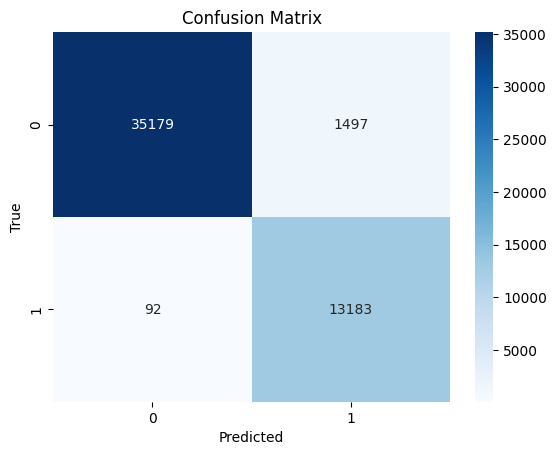

[BalancedAccuracy: 65.08%, F1: 94.32%, Precision: 89.81%, Recall: 99.31%]


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(metric)

The model yields very good results, this is probably due to the fact that the neural network was trained on the same data that we are using to test it. In a real scenario, the neural network would be trained on a different dataset, and the results would be worse. Moreover, the features extracted from the neural network contain a lot of the information of the original data, so the problem of anomaly detection is greatly simplified.

## Let's try with a Half Space Tree

In [10]:
import river
from river import anomaly
from river import compose
from river import preprocessing

model = compose.Pipeline(
    preprocessing.MinMaxScaler(),
    anomaly.HalfSpaceTrees()
)

# Evaluate the model
river.evaluate.progressive_val_score(dataset, model, metric=metrics.ROCAUC(),
                                     print_every=10000)

[10,000] ROCAUC: 93.39%
[20,000] ROCAUC: 93.86%
[30,000] ROCAUC: 94.08%
[40,000] ROCAUC: 94.32%
[49,950] ROCAUC: 94.33%


ROCAUC: 94.33%

As expected, also Half Space Tree do a decent job at identifying anomalies.

# Machine specific approach

Now let's train a different model for each machine, and see if the results improve.

In [11]:
# Arrange results in a dataframe
import pandas as pd

results = pd.DataFrame(columns=['model', 'ROC-AUC'])

for dataset_label in data.keys():
    model = compose.Pipeline(
        preprocessing.MinMaxScaler(),
        anomaly.HalfSpaceTrees()
    )
    X = data[dataset_label][0]
    y = data[dataset_label][1]
    X = new_model.predict(X)
    dataset = [({j: X[i,j] for j in range(X.shape[1])}, y[i]) for i in range(X.shape[0])]
    eval_results = river.evaluate.progressive_val_score(dataset, model, metric=metrics.ROCAUC())
    results = pd.concat([results, pd.DataFrame({'model': [dataset_label], 'ROC-AUC': eval_results})])

results

387/387 [==============================] - 0s 723us/step


,model,ROC-AUC
0,00,ROCAUC: 82.54%
0,02,ROCAUC: 58.80%
0,04,ROCAUC: 81.34%
0,06,ROCAUC: 39.12%
